In [2]:
import numpy as np
import os
import librosa
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
audio_folder = r"C:\Users\dandr\Documents\DataMining\FinalProject\audio_files"
data = []
# Recorremos las subcarpetas de "audio_files"
for bird_folder in os.listdir(audio_folder):
    print(bird_folder)
    # Obtenemos el nombre del pajaro
    bird_name = bird_folder

    # Recorremos los archivos de la subcarpeta
    for file in os.listdir(os.path.join(audio_folder, bird_folder)):
        if file.endswith(".mp3"):
            # Cargamos el archivo de audio y el archivo de texto
            audio_path = os.path.join(audio_folder, bird_folder, file)
            text_path = os.path.join(audio_folder, bird_folder, file.replace(".mp3", ".txt"))

            # Cargamos el audio con librosa
            y, sr = librosa.load(audio_path)

            # Leemos el archivo de texto y cortamos el audio
            with open(text_path, "r") as f:
                for line in f:
                    start_time, end_time, label = line.strip().split("\t")
                    start_frame = librosa.time_to_samples(float(start_time))
                    end_frame = librosa.time_to_samples(float(end_time))
                    cut_audio = y[start_frame:end_frame]

                    if len(cut_audio) > 0:
                      # Calcular la longitud de la ventana y el salto de forma proporcional al tamaño del audio cortado
                      window_length = len(cut_audio) // 4  # Puedes ajustar el factor como creas conveniente
                      hop_length = window_length // 4  # Puedes ajustar el factor como creas conveniente

                      mfcc = librosa.feature.mfcc(y=cut_audio, sr=sr, n_mfcc=13, n_fft=window_length, hop_length=hop_length)
                      zcr = librosa.feature.zero_crossing_rate(y=cut_audio, frame_length=window_length, hop_length=hop_length)
                      spectral_centroid = librosa.feature.spectral_centroid(y=cut_audio, sr=sr, n_fft=window_length, hop_length=hop_length)
                      spectral_flux = librosa.onset.onset_strength(S=librosa.feature.melspectrogram(y=cut_audio, sr=sr, n_fft=window_length, hop_length=hop_length))
                      spectral_bandwidth = librosa.feature.spectral_bandwidth(y=cut_audio, sr=sr, n_fft=window_length, hop_length=hop_length)
                      energy = librosa.feature.rms(y=cut_audio, frame_length=window_length, hop_length=hop_length)

                      zcr = zcr.reshape(-1, 1)
                      spectral_centroid = spectral_centroid.reshape(-1, 1)
                      spectral_flux = spectral_flux.reshape(-1, 1)
                      spectral_bandwidth = spectral_bandwidth.reshape(-1, 1)
                      energy = energy.reshape(-1, 1)

                      features = np.concatenate((zcr, spectral_centroid, spectral_flux, spectral_bandwidth, energy, mfcc.T), axis=1)

                      for f in features:
                          row = f.tolist()
                          row.append(bird_name)
                          data.append(row)

Acrocephalus arundinaceus
Acrocephalus melanopogon
Acrocephalus scirpaceus
Alcedo atthis
Anas platyrhynchos
Anas strepera
Ardea purpurea
Botaurus stellaris
Charadrius alexandrinus


c:\Users\dandr\anaconda3\envs\mining\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Ciconia ciconia
Circus aeruginosus
Coracias garrulus
Dendrocopos minor
Fulica atra
Gallinula chloropus
Himantopus himantopus
Ixobrychus minutus
Motacilla flava
Porphyrio porphyrio
Tachybaptus ruficollis


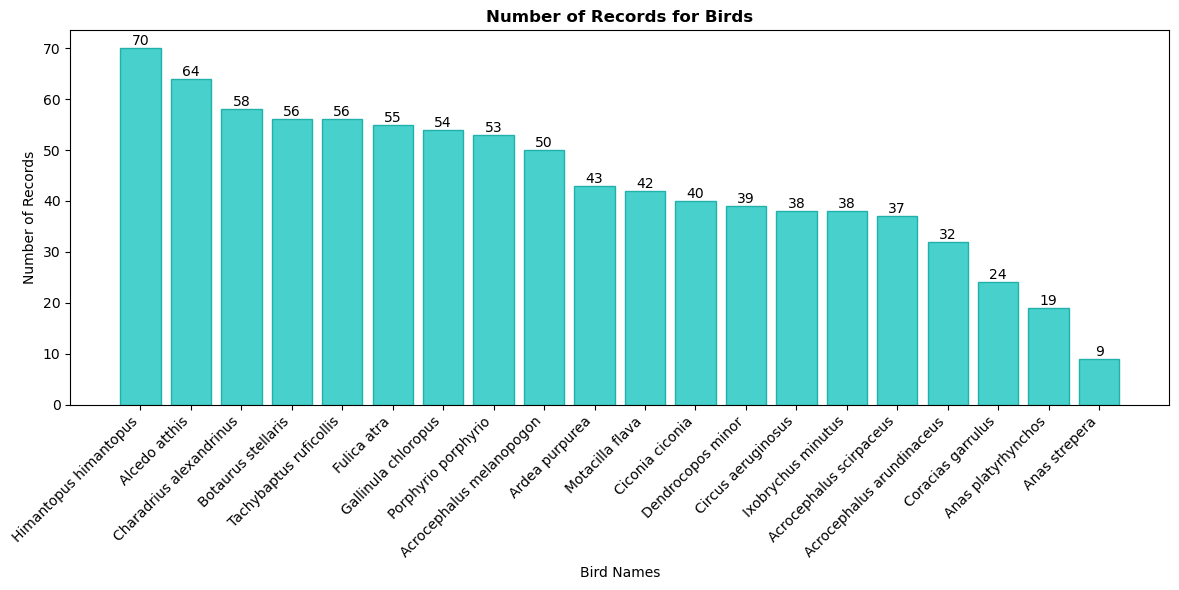

In [10]:
def count_files_in_subfolders(main_folder):
    subfolder_counts = {}
    # root is the current directory path
    # dirs is a list of subdirectories in the current directory
    # files is a list of files in the current directory
    for root, dirs, files in os.walk(main_folder):
        # Count only in subfolders, not in the main folder itself
        if root != main_folder:
            mp3_files = [file for file in files if file.endswith(".mp3")]
            subfolder_name = os.path.basename(root)
            subfolder_counts[subfolder_name] = len(mp3_files)
    return subfolder_counts


def plot_histogram(subfolder_counts):
    # Extract counts and subfolder names
    sorted_subfolders = sorted(subfolder_counts.items(), key=lambda x: x[1], reverse=True)

    # Extract counts and subfolder names after sorting
    counts = [count for subfolder, count in sorted_subfolders]
    subfolders = [subfolder for subfolder, count in sorted_subfolders]

    # Plot histogram
    plt.figure(figsize=(12, 6))
    bars = plt.bar(subfolders, counts, color='mediumturquoise', edgecolor='lightseagreen')
    plt.xlabel('Bird Names')
    plt.ylabel('Number of Records')
    plt.title('Number of Records for Birds', weight='bold')
    plt.xticks(rotation=45, ha='right')

    # Add counts above each bar
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
                 ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Replace 'your_main_folder_path' with the path to your main folder
main_folder_path = r'C:\Users\dandr\Documents\DataMining\FinalProject\audio_files'

# Count files in subfolders
subfolder_counts = count_files_in_subfolders(main_folder_path)

# Plot histogram with bars ordered in descending order and counts above each bar
plot_histogram(subfolder_counts)

In [4]:
# create a dataframe with the features
columns = ['zero_crossing_rate', 'spectral_centroid', 'spectral_flux', 'spectral_bandwidth',
          'energy']
columns.extend(['mfcc_{}'.format(i) for i in range(13)])
columns.append('label')

df_feat = pd.DataFrame(data, columns=columns)
df_feat.to_csv(r"C:\Users\dandr\Documents\DataMining\FinalProject\birds_song_features.csv", index=False)

# Read the dataset of the features extracted previously as pandas dataframe

In [4]:
feat_path = r"C:\Users\dandr\Documents\DataMining\FinalProject\birds_song_features.csv"
df_feat: pd.DataFrame = pd.read_csv(feat_path, sep=',', engine='python')
df_feat = df_feat.reset_index(drop=True)
df_feat.shape
df_feat.head()

,zero_crossing_rate,spectral_centroid,spectral_flux,spectral_bandwidth,energy,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,label
0,0.118351,2712.265712,0.000000,1492.215149,0.009571,-159.954407,48.081062,-88.687401,40.231564,32.134190,-21.364832,-10.426442,16.711760,-5.212798,-12.775089,3.981515,8.670467,-11.643007,Acrocephalus arundinaceus
1,0.178020,2756.932485,0.000000,1574.705233,0.014396,-134.861328,47.345406,-84.614365,35.675282,26.029396,-23.277294,-9.954340,16.837711,-3.478797,-13.044092,2.409059,10.071982,-12.861805,Acrocephalus arundinaceus
2,0.244724,2813.880028,0.000000,1529.307362,0.014778,-130.199677,37.930416,-88.494141,34.570595,20.474033,-25.950497,-5.239628,19.985954,-0.095222,-11.079509,4.812685,10.298313,-10.691683,Acrocephalus arundinaceus
3,0.259842,3059.333291,0.388016,1823.557484,0.013585,-136.702393,35.381226,-65.295288,41.848434,15.442682,-18.100002,1.145718,18.633413,5.023622,-6.789618,6.826590,14.270391,-5.846300,Acrocephalus arundinaceus
4,0.258176,3603.301285,0.585187,2059.791583,0.022377,-157.415344,29.678467,-38.216217,43.706772,-5.005262,-11.100969,12.879740,8.975576,-0.857690,-1.721299,4.014203,10.099804,-2.637583,Acrocephalus arundinaceus


In [9]:
# Training the Support Vector Machine (SVM)
X = df_feat.drop(columns=['label'])
y = df_feat['label']

# Encode labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Standardize the features because the SVM model is very sensitive to the scale of the variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train an SVM classifier with scaled features
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Evaluate the SVM model
y_pred_test = svm_model.predict(X_test_scaled)

El Reporte de clasificación proporciona varias métricas para cada clase y un resumen general de su modelo de clasificación multiclase.

In [14]:
# Accuracy of the SVM model
# print("Accuracy - Training data: {} " .format(accuracy_score(y_train, y_pred_test)))
print("Accuracy - Testing data: {} ". format(accuracy_score(y_test, y_pred_test)))

# Additional evaluation metrics
print(classification_report(y_test, y_pred_test, target_names=label_encoder.classes_))

Accuracy - Testing data: 0.7238502238502238 
                           precision    recall  f1-score   support

Acrocephalus arundinaceus       0.71      0.82      0.76      2225
 Acrocephalus melanopogon       0.57      0.58      0.57      1114
  Acrocephalus scirpaceus       0.70      0.58      0.63       635
            Alcedo atthis       0.80      0.82      0.81      2127
       Anas platyrhynchos       0.60      0.51      0.55       354
            Anas strepera       0.69      0.64      0.67       477
           Ardea purpurea       0.53      0.44      0.48      1033
       Botaurus stellaris       0.89      0.97      0.93      2245
  Charadrius alexandrinus       0.54      0.68      0.60      1969
          Ciconia ciconia       0.79      0.72      0.75       625
       Circus aeruginosus       0.60      0.52      0.56      1595
        Coracias garrulus       0.54      0.56      0.55      1317
        Dendrocopos minor       0.90      0.93      0.92      2526
              Fu

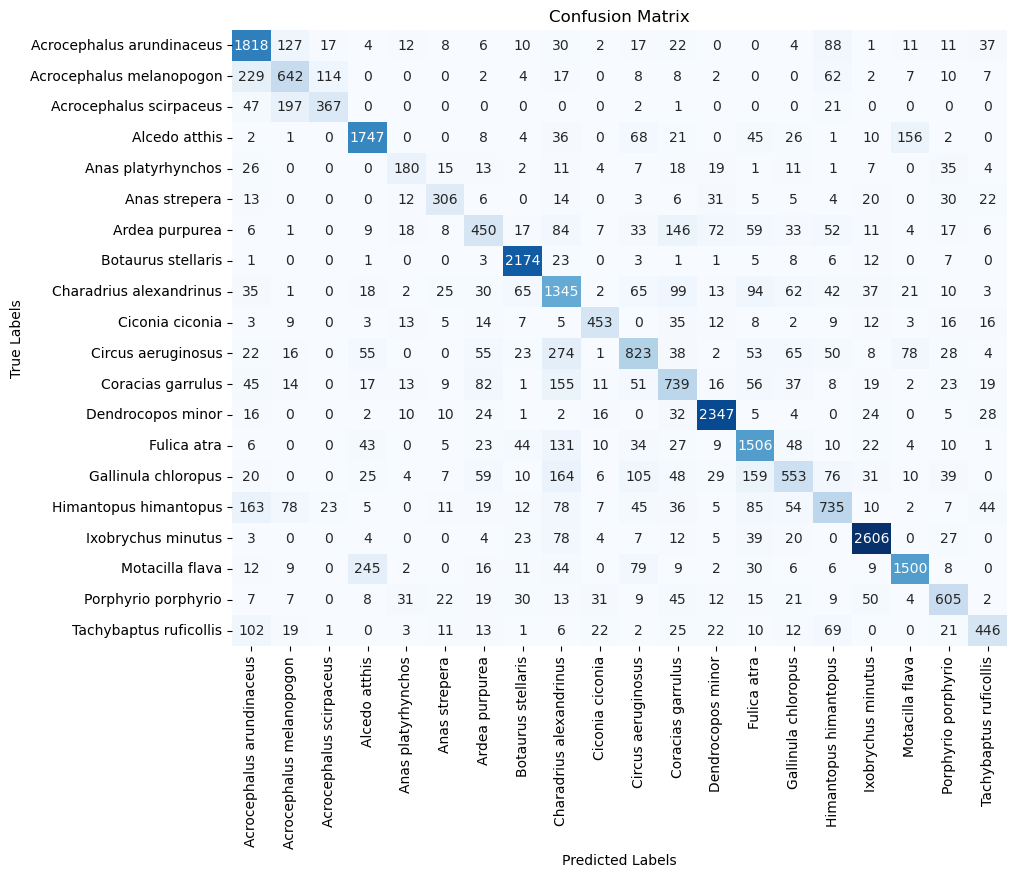

In [17]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Assuming 'class_names' is a list containing your class labels
class_names = ["Acrocephalus arundinaceus", "Acrocephalus melanopogon", "Acrocephalus scirpaceus",
               "Alcedo atthis", "Anas platyrhynchos", "Anas strepera", "Ardea purpurea",
               "Botaurus stellaris", "Charadrius alexandrinus", "Ciconia ciconia",
               "Circus aeruginosus", "Coracias garrulus", "Dendrocopos minor",
               "Fulica atra", "Gallinula chloropus", "Himantopus himantopus",
               "Ixobrychus minutus", "Motacilla flava", "Porphyrio porphyrio", "Tachybaptus ruficollis"]

# Create a DataFrame for better visualization (optional, but recommended)
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# We need to balance our dataset
There are several techniques we can use to balance the dataset before training our Ml model. 
In this case, we use the Synthetic Minority Over-sampling Technique (SMOTE).
This generate synthetic samples for the minority class by interpolating between 
existing instances. Also, this helps in balancing the dataset without replicating
existing instances.

In [5]:
df_feat["label"].value_counts()

Ixobrychus minutus           9469
Dendrocopos minor            8398
Acrocephalus arundinaceus    7480
Botaurus stellaris           7412
Alcedo atthis                7106
Motacilla flava              6800
Charadrius alexandrinus      6375
Fulica atra                  6324
Circus aeruginosus           5236
Himantopus himantopus        4709
Coracias garrulus            4539
Gallinula chloropus          4454
Acrocephalus melanopogon     3757
Ardea purpurea               3519
Porphyrio porphyrio          3162
Tachybaptus ruficollis       2601
Ciconia ciconia              2057
Acrocephalus scirpaceus      2057
Anas strepera                1632
Anas platyrhynchos           1190
Name: label, dtype: int64

In [6]:
# Training the Support Vector Machine (SVM)
X = df_feat.drop(columns=['label'])
y = df_feat['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_balanced)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Assuming y_train_resampled is your balanced target variable
class_counts = pd.Series(y_balanced).value_counts()
print("Number of features for each bird:")
print(class_counts)

Number of features for each bird:
Tachybaptus ruficollis       6637
Acrocephalus melanopogon     6637
Porphyrio porphyrio          6637
Fulica atra                  6637
Alcedo atthis                6637
Acrocephalus scirpaceus      6637
Himantopus himantopus        6637
Gallinula chloropus          6637
Anas platyrhynchos           6637
Ardea purpurea               6637
Coracias garrulus            6637
Circus aeruginosus           6637
Anas strepera                6637
Motacilla flava              6637
Charadrius alexandrinus      6637
Ixobrychus minutus           6637
Acrocephalus arundinaceus    6637
Dendrocopos minor            6637
Botaurus stellaris           6637
Ciconia ciconia              6637
Name: label, dtype: int64


In [10]:
# Initialize and train the model
svm_model = SVC(kernel='linear', C=1.0)
# svm_model.fit(X_train_scaled, y_balanced)
svm_model.fit(X_balanced, y_balanced) # type: ignore
# Evaluate the model
# y_pred_test = svm_model.predict(X_test_scaled)
y_pred_test = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)

In [16]:
# Additional evaluation metrics
# Support: número de registros de cada clase en los datos del reporte de clasificación
print(classification_report(y_test, y_pred_test))

                           precision    recall  f1-score   support

Acrocephalus arundinaceus       0.67      0.72      0.69      1909
 Acrocephalus melanopogon       0.56      0.58      0.57      1843
  Acrocephalus scirpaceus       0.74      0.76      0.75      1822
            Alcedo atthis       0.80      0.83      0.81      1898
       Anas platyrhynchos       0.69      0.70      0.69      1858
            Anas strepera       0.73      0.76      0.74      1882
           Ardea purpurea       0.55      0.53      0.54      1870
       Botaurus stellaris       0.88      0.96      0.92      1941
  Charadrius alexandrinus       0.54      0.63      0.58      1924
          Ciconia ciconia       0.82      0.82      0.82      1945
       Circus aeruginosus       0.62      0.54      0.57      1909
        Coracias garrulus       0.53      0.59      0.56      1878
        Dendrocopos minor       0.88      0.89      0.89      1850
              Fulica atra       0.68      0.76      0.72     

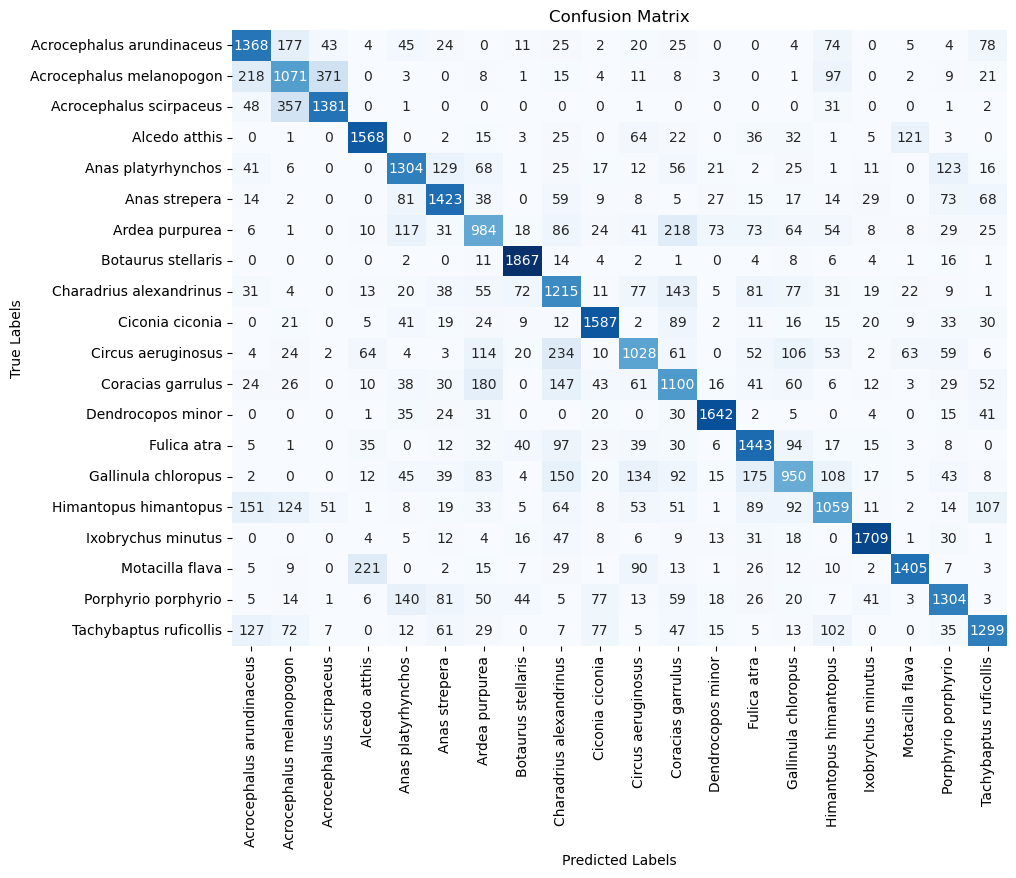

In [18]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Assuming 'class_names' is a list containing your class labels
class_names = ["Acrocephalus arundinaceus", "Acrocephalus melanopogon", "Acrocephalus scirpaceus",
               "Alcedo atthis", "Anas platyrhynchos", "Anas strepera", "Ardea purpurea",
               "Botaurus stellaris", "Charadrius alexandrinus", "Ciconia ciconia",
               "Circus aeruginosus", "Coracias garrulus", "Dendrocopos minor",
               "Fulica atra", "Gallinula chloropus", "Himantopus himantopus",
               "Ixobrychus minutus", "Motacilla flava", "Porphyrio porphyrio", "Tachybaptus ruficollis"]

# Create a DataFrame for better visualization (optional, but recommended)
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()